In [1]:
import networkx as nx
import numpy as np
import itertools as it
import random
import time
import scipy
from matplotlib import pyplot as plt
import fresnel

In [2]:
np.random.seed(101)
random.seed(101)

In [3]:
def coordination_pattern(x):
    """
    To do: obtain the neighbors of an input atom position
    Args:
        x: the position of atoms
    Returns:
        the neighbors of the atoms, excluding the center atoms
    """
    return np.array([x+np.array([0.5,0.5,0]),
                     x+np.array([-0.5,0.5,0]),
                     x+np.array([0.5,-0.5,0]),
                     x+np.array([-0.5,-0.5,0]),
                     x+np.array([0.5,0,0.5]),
                     x+np.array([0.5,0,-0.5]),
                     x+np.array([-0.5,0,0.5]),
                     x+np.array([-0.5,0,-0.5]),
                     x+np.array([0,0.5,0.5]),
                     x+np.array([0,-0.5,0.5]),
                     x+np.array([0,0.5,-0.5]),
                     x+np.array([0,-0.5,-0.5]),
                    ])
def neighbors(x):
    """
    To do: obtain the occupied sites for a given cell
    Args:
        x: the position of cells
    Returns:
        the occupied sites in the cells
    """
    #define sites of fcc cell where x is the body center
    return np.array([x+np.array([0.5,0,0]),
                     x+np.array([-0.5,0,0]),
                     x+np.array([0,-0.5,0]),
                     x+np.array([0,0.5,0]),
                     x+np.array([0,0,0.5]),
                     x+np.array([0,0,-0.5]),      
                     x+np.array([0.5,0.5,0.5]),
                     x+np.array([-0.5,-0.5,0.5]),
                     x+np.array([0.5,-0.5,0.5]),
                     x+np.array([-0.5,0.5,0.5]),           
                     x+np.array([0.5,0.5,-0.5]),
                     x+np.array([-0.5,-0.5,-0.5]),
                     x+np.array([0.5,-0.5,-0.5]),
                     x+np.array([-0.5,0.5,-0.5])   
                    ])

In [4]:
def addition_event():
    #addition
    site_surface_site_temp=random.choice(site_vacant_list)
    coor_num=site_all.nodes[site_surface_site_temp]["coor_num"]
    #set probability distribution
    fc=len(site_vacant_list)/len(site_surface_list)*np.exp(-(beta)*(-miu-E*coor_num))
    accept_probability=1/(1+1/fc)
    flag=np.random.choice([False,True],1,p=[1-accept_probability,accept_probability]).item()
    #main part    
    if flag==False:
        return flag,site_surface_site_temp
    else:
        #deal with the center atom first
        site_vacant_list.remove(site_surface_site_temp) #remove the site from the vacant list
        site_atoms_list.append(site_surface_site_temp)
        
        site_all.nodes[site_surface_site_temp]["site"]="Au" #change the vacant site to atom site
        if site_all.nodes[site_surface_site_temp]["coor_num"]!=max_coor_num: #if the this atom is not saturated,add to the surface atom
            site_surface_list.append(site_surface_site_temp)
        
        #deal with the neighbor
        coor_sites=coordination_pattern(site_surface_site_temp)
        for coor_site in coor_sites:
            coor_site=tuple(coor_site)
            # if this neighbor dosen't exist in the overall site, it's a vacant site and should be added
            if site_all.has_node(coor_site)==False:
                site_vacant_list.append(coor_site)
                site_all.add_node(coor_site)
                site_all.nodes[coor_site]["coor_num"]=1
                site_all.nodes[coor_site]["site"]="vacant"
            # if this neighbor exists in the overall site, the coordination number is increased by 1.
            # then if it's atom site and saturated, we should delete it from surface atom
            else:
                site_all.nodes[coor_site]["coor_num"]=site_all.nodes[coor_site]["coor_num"]+1
                if site_all.nodes[coor_site]["coor_num"]==max_coor_num and site_all.nodes[coor_site]["site"]=="Au":
                    site_surface_list.remove(coor_site)
        
        return flag,site_surface_site_temp

In [5]:
def deletion_event():
    #deletion
    site_surface_site_temp=random.choice(site_surface_list)
    coor_num=site_all.nodes[site_surface_site_temp]["coor_num"]
    #set probability distribution
    fc=len(site_surface_list)/len(site_vacant_list)*np.exp(-(beta)*(miu+E*coor_num))
    accept_probability=1/(1+1/fc)
    flag=np.random.choice([False,True],1,p=[1-accept_probability,accept_probability]).item()
    
    #main part
    if flag==False:
        return flag,site_surface_site_temp
    else:
        #deal with the center atom first
        site_surface_list.remove(site_surface_site_temp) #remove the site from the surface list
        site_atoms_list.remove(site_surface_site_temp)
        site_all.nodes[site_surface_site_temp]["site"]="vacant" #change the surface site to vacant site

        if site_all.nodes[site_surface_site_temp]["coor_num"]!=0: #if this vacant site is attached to any atoms
            site_vacant_list.append(site_surface_site_temp)
        else:
            site_all.remove_node(site_surface_site_temp)

        #deal with the neighbor
        coor_sites=coordination_pattern(site_surface_site_temp)
        for coor_site in coor_sites:
            coor_site=tuple(coor_site)
            # if this neighbor dosen't exist in the overall site, it's a mistake
            if site_all.has_node(coor_site)==False:
                print("Error!")
            # by deleting the atom, the coordination numbers of the neighbors are all decreased by 1
            else:
                site_all.nodes[coor_site]["coor_num"]=site_all.nodes[coor_site]["coor_num"]-1
                # if the coordination number is decrease to 0, meaning a detachment happended, if the site is vacant, it's removed
                if site_all.nodes[coor_site]["coor_num"]==0 and site_all.nodes[coor_site]["site"]=="vacant":
                    site_all.remove_node(coor_site)
                    site_vacant_list.remove(coor_site)
                # it will also make the transform from body atom to surface atom
                elif site_all.nodes[coor_site]["coor_num"]==max_coor_num-1 and site_all.nodes[coor_site]["site"]=="Au":
                    site_surface_list.append(coor_site)
                    
        return flag,site_surface_site_temp

In [6]:
site_all=nx.Graph()
site_vacant=nx.Graph()
site_surface=nx.Graph()
site_atoms=nx.Graph()
max_coor_num=12

In [7]:
position = []
for x in range(-50,50):
    for y in range(-50,50):
        for z in range(-50,50):
            if abs(x)+abs(y)+abs(z)<=16:
                position.append([x,y,z])
position = np.array(position)
position = np.array(neighbors(position).flatten().reshape(-1,3))
position = np.unique(position,axis=1)

In [8]:
#create the initial shape of an_octahedron
for i in position:
    #if some criteria is satisfied
    site_all.add_node(tuple(i))
site_atoms.add_nodes_from(site_all)
site_atoms_list=list(site_atoms)

In [9]:
print(len(site_atoms_list))

27438


In [10]:
#calculate the initial surface atoms, vacant sites and corresponding coordination numbers
#for all the atoms
for site_all_list_temp in site_atoms_list:
    #obtain the coordinated atoms to that specific atom
    coor=coordination_pattern(np.asarray(site_all_list_temp))
    #begin to count how many atoms already exsting in the site list
    coor_num=0
    for coor_temp in coor:
        coor_temp=tuple(coor_temp)
        if site_atoms.has_node(coor_temp):
            coor_num=coor_num+1
        else:
            # if not exist, it's a vacant site, so we add it to the overall site and vacant site graph
            if site_vacant.has_node(coor_temp):
                site_all.nodes[coor_temp]["coor_num"]=site_all.nodes[coor_temp]["coor_num"]+1
            else:
                site_all.add_node(tuple(coor_temp))
                site_vacant.add_node(tuple(coor_temp))
                site_all.nodes[coor_temp]["coor_num"]=1
                site_all.nodes[coor_temp]["site"]="vacant"
    #record the coordination of that specific atom        
    site_all.nodes[site_all_list_temp]["coor_num"]=coor_num
    site_all.nodes[site_all_list_temp]["site"]="Au"
    
    #if the coordination number is not saturated, it's a surface atom and add to the surface atom graph
    if coor_num<max_coor_num:
        site_surface.add_node(site_all_list_temp)
        
site_surface_list=list(site_surface)
site_vacant_list=list(site_vacant)

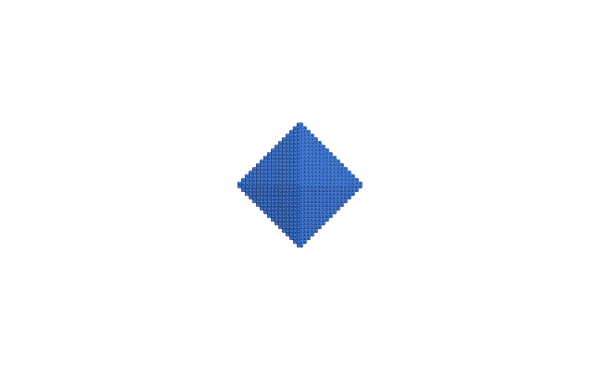

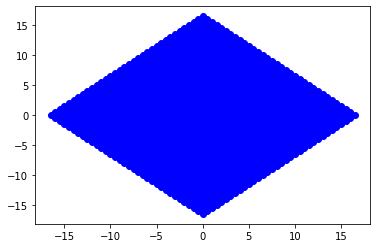

In [11]:
data=np.array(list(site_atoms))
data_plot=data[data[:,2]==0]
plt.scatter(data_plot[:,0],data_plot[:,1],c="b")

scene = fresnel.Scene()
geometry1 = fresnel.geometry.Sphere(scene, N=len(data), radius=0.4)
geometry1.position[:] = data
geometry1.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]),
                                              roughness=0.8)
fresnel.preview(scene)

In [12]:
#define the kinetic constant for simulation
k=-6.0
E=0.3275
miu=k*E
kT=0.0259
beta=1/kT

In [13]:
size_original=len(site_atoms_list)
geometry=[]
len1=len(site_atoms_list)

In [14]:
step_num = 0
atoms_changes = []
atoms_changes_type = []
flag_total = []
s1 = 0
s2 = 0
flag_count = 0
while abs((len(site_atoms_list)-size_original)/size_original)<0.9:
    a1 = len(site_atoms_list)
    event_index = np.random.randint(2)
    if event_index==0:
        flag,site_surface_site_temp = addition_event()
        if flag == True:
            atoms_changes.append(list(site_surface_site_temp))
            atoms_changes_type.append([1])
            s2 = s2+ 1
    else:
        flag,site_surface_site_temp = deletion_event()
        if flag == True:
            atoms_changes.append(list(site_surface_site_temp))
            atoms_changes_type.append([2])
            s2 = s2 - 1
    if flag == False:
        atoms_changes_type.append([3])
    step_num = step_num + 1
    a2 = len(site_atoms_list)
    if step_num%(10**2) == 0:
        atoms_changes = np.array(atoms_changes)
        atoms_changes_type = np.array(atoms_changes_type)
        np.savetxt('./data2/atoms_changes%d.csv'%step_num,atoms_changes,delimiter=',')
        np.savetxt('./data2/atoms_changes_type%d.csv'%step_num,atoms_changes_type,delimiter=',')
        s1 = s1 + (atoms_changes_type == 1).sum() - (atoms_changes_type == 2).sum()
        atoms_changes = []
        atoms_changes_type = []

In [15]:
step_num

2009122

2743


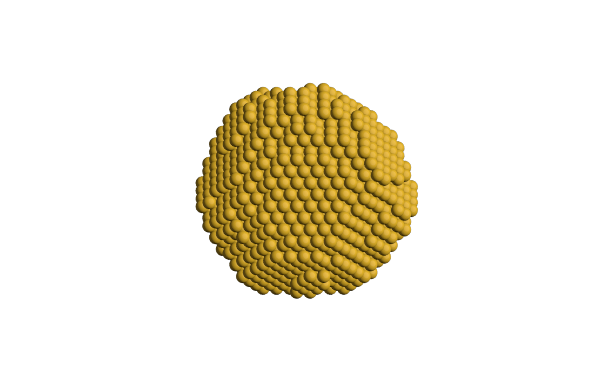

In [16]:
scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=len(site_atoms_list), radius=0.5*np.sqrt(2)/2)
geometry.position[:] = site_atoms_list
geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.9, 0.714, 0.169]), roughness = 0.2)
scene.camera = fresnel.camera.Orthographic.fit(scene)
print(len(site_atoms_list))
fresnel.preview(scene)